In [2]:
# Package import
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
from skimage.measure import regionprops
from skimage import data
from skimage.exposure import histogram
from skimage.color import label2rgb
from scipy import ndimage as ndi
from scipy.signal import medfilt2d
from skimage.filters import gaussian
import pandas as pd


# Plot parameter setting 
plt.style.use('default')
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['figure.dpi'] = 100

In [1]:
# Access Manually Identified Bowties
# os.chdir("..")
os.chdir("./Manually Identified Bowties/") # Can change to 'Manually Identified Other'
print(os.getcwd()) # Verify that you're in the folded 'Manually Identified Bowties'

c:\Users\aaris\Downloads\Topic 2\Topic 2\Manually Identified Bowties


In [3]:
l0 = [k for k in os.listdir() if '_0.npy' in k]
l45 = [k for k in os.listdir() if '_45.npy' in k]

WORKING MODEL (WITHOUT IMAGE FILTERING) (1st iteration)

(SUCCESSFUL)

In [4]:
# Initialize empty arrays to save area values corresponding to file number
areaArray = []
secondArray = []

# For selected file in the specified directory
for i in range(0, len(l0)):
    filename = l45[i]

    # Load some file named filename in Manually Identified Bowties
    file = np.load(filename)

    try:
        minimumValue = np.min(file)
        maximumValue = np.max(file)
        meanValue = np.mean(file)
        stdValue = np.std(file)
            
        # Use 3 sigma for upper and lower control limits
        UCL = meanValue + 3*stdValue
        LCL = meanValue - 3*stdValue

        ratioMin = abs(minimumValue/meanValue)
        ratioMax = abs(maximumValue/meanValue)

        markers = np.zeros_like(file)

        # To decide limits for the mask
        # if ratioMin > ratioMax:
        markers[file < LCL] = 1 # Tune your threshold
        # else:
        markers[file > UCL] = 1 # Tune your threshold

        # markers[file > 10] = 1

        labeled_area, n = ndi.label(markers)  # label the connected components

        count = 0

        # Print the area info
        for region in regionprops(labeled_area):
            # If the area is small and not desired, ignore it
            if region.area < 4:
                continue

            # draw rectangle around segmented coins
            areaArray.append('Area %i: Area %i' % (i, region.area))
            # print('Area %i: Area %i' % (i, region.area))
            # print('Area %i: Area %i' % (i, region.bbox_area))

            count += 1

        secondArray.append(count)
        
    except ValueError:  # raised if file is empty.
        pass

In [5]:
# For Manually Identified Bowties, this is the accuracy rate of recognizing bowties
# For Manually Identified Other, this is the error rate of falsely identifying bowties
amountRecognized = np.count_nonzero(secondArray)

print(amountRecognized)
print(amountRecognized/len(secondArray))

397
0.7861386138613862


DEFINE FUNCTIONS FOR IMAGE FILTERING

In [5]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

In [6]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    try:
        # Assuming a rectangular image
        tgt_size = calculate_target_size(
            img_size=img.shape[0],
            kernel_size=kernel.shape[0]
        )
        # To simplify things
        k = kernel.shape[0]
        
        # 2D array of zeros
        convolved_img = np.zeros(shape=(tgt_size, tgt_size))
        
        # Iterate over the rows
        for i in range(tgt_size):
            # Iterate over the columns
            for j in range(tgt_size):
                # img[i, j] = individual pixel value
                # Get the current matrix
                mat = img[i:i+k, j:j+k]
                
                # Apply the convolution - element-wise multiplication and summation of the result
                # Store the result to i-th row and j-th column of our convolved_img array
                convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    except ValueError:  # raised if file is empty.
        pass
            
    return convolved_img

AUTOMATED ATTEMPT WITH IMAGE FILTERING (2nd iteration)

(SUCCESSFUL)

In [19]:
# Initialize empty arrays to save area values corresponding to file number
areaArray = []
secondArray = []
customKernel = np.array([[ -1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

# For selected file in the specified directory
for i in range(0, len(l0)):
    filename = l45[i]

    # Load some file named filename in Manually Identified Bowties
    image = np.load(filename)

    image = gaussian(image)

    file = convolve(img=image, kernel=customKernel)

    try:
        minimumValue = np.min(file)
        maximumValue = np.max(file)
        meanValue = np.mean(file)
        stdValue = np.std(file)
            
        # Use 3 sigma for upper and lower control limits
        UCL = meanValue + 2.75*stdValue
        LCL = meanValue - 2.75*stdValue

        ratioMin = abs(minimumValue/meanValue)
        ratioMax = abs(maximumValue/meanValue)

        markers = np.zeros_like(file)

        # To decide limits for the mask
        # if ratioMin > ratioMax:
        markers[file < LCL] = 1 # Tune your threshold
        # else:
        markers[file > UCL] = 1 # Tune your threshold

        # markers[file > 10] = 1

        labeled_area, n = ndi.label(markers)  # label the connected components

        count = 0

        # Print the area info
        for region in regionprops(labeled_area):
            # If the area is small and not desired, ignore it
            if region.area < 4:
                continue

            # draw rectangle around segmented coins
            areaArray.append('Area %i: Area %i' % (i, region.area))
            # print('Area %i: Area %i' % (i, region.area))
            # print('Area %i: Area %i' % (i, region.bbox_area))

            count += 1

        secondArray.append(count)
        
    except ValueError:  # raised if file is empty.
        pass

In [20]:
# For Manually Identified Bowties, this is the accuracy rate of recognizing bowties
# For Manually Identified Other, this is the error rate of falsely identifying bowties
amountRecognized = np.count_nonzero(secondArray)

print(amountRecognized)
print(amountRecognized/len(secondArray))

340
0.6563706563706564


MANUAL EXPERIMENTATION WITH IMAGE FILTERING

In [7]:
## CUSTOM KERNEL/FILTER ATTEMPT

from skimage.filters import gaussian

customKernel = np.array([[ -1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

i = 6

filename0, filename45 = l0[i], l45[i]

file0, file45 = np.load(filename0), np.load(filename45)

subset = file0[0:0+3, 0:0+3]

val = np.multiply(subset, customKernel)

file0 = gaussian(file0)

imageNew = convolve(img=file0, kernel=customKernel)

minimumValue = np.min(imageNew)
maximumValue = np.max(imageNew)
meanValue = np.mean(imageNew)
stdValue = np.std(imageNew)
    
# Use 3 sigma for upper and lower control limits
UCL = meanValue + 3*stdValue
LCL = meanValue - 3*stdValue

print("UCL:", UCL)
print("LCL:", LCL)

UCL: 53.91844566670791
LCL: -47.766139047102726


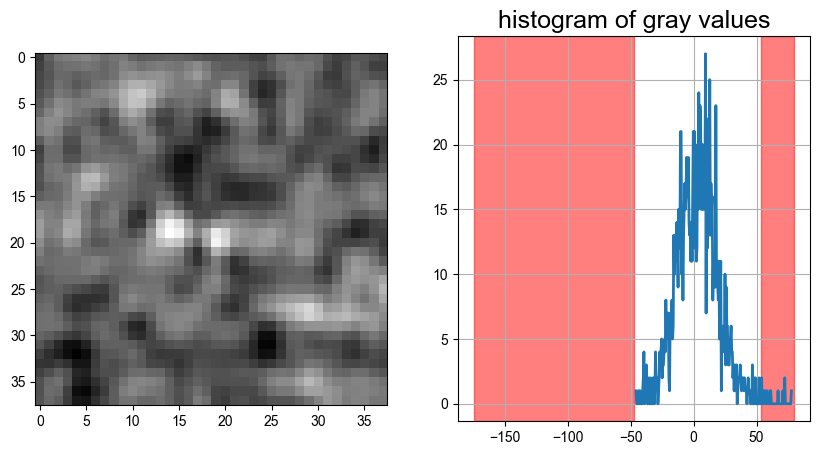

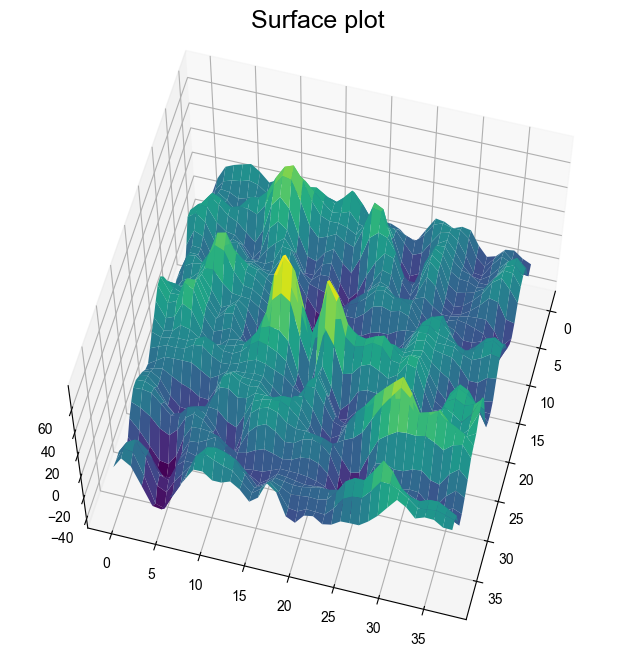

In [8]:
from skimage.exposure import histogram

# Histogram Plot
hist, hist_centers = histogram(imageNew)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(imageNew, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()
axes[1].axvspan(UCL, 80, 0, 1, color = 'red', alpha = 0.5)
axes[1].axvspan(-175, LCL, 0, 1, color = 'red', alpha = 0.5)


# 3D
Rn = np.shape(imageNew)[0]
Cn = np.shape(imageNew)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, imageNew, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

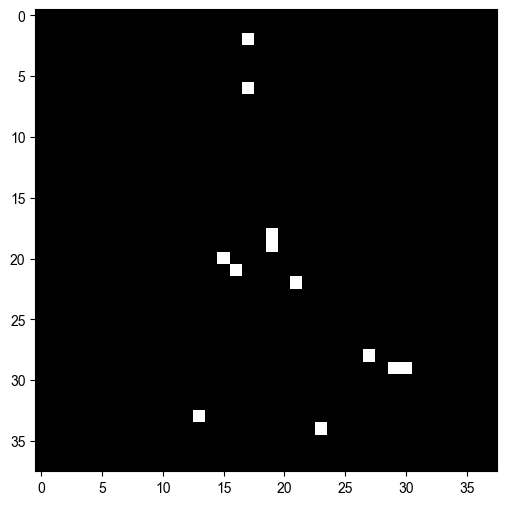

In [45]:
markers = np.zeros_like(imageNew)

# To decide limits for the mask
# if ratioMin > ratioMax:
#     markers[file < LCL] = 1 # Tune your threshold
# else:
#     markers[file > UCL] = 1 # Tune your threshold

markers[imageNew < LCL] = 1
markers[imageNew > UCL] = 1

# markers[file > 10] = 1
    
# Contour and BBox
plt.figure()
plt.imshow(markers, cmap='gray')

ATTEMPT TO USE MEDIAN FILTERING ON DATA

(UNSUCCESSFUL)

In [671]:
## MEDIAN FILTER ATTEMPT
from scipy.signal import medfilt2d

# Load some file in Manually Identified Bowties
# for i in range(0, len(l0)):
i = 6

filename0, filename45 = l0[i], l45[i]

file0, file45 = np.load(filename0), np.load(filename45)

new = medfilt2d(file0)

first = file0

# for i in range(0, len(file0)):

minimumValue = np.min(first)
maximumValue = np.max(first)
meanValue = np.mean(first)
stdValue = np.std(first)
    
# Use 3 sigma for upper and lower control limits
UCL = meanValue + 3*stdValue
LCL = meanValue - 3*stdValue

print("UCL:", UCL)
print("LCL:", LCL)


UCL: 17.051271162905007
LCL: -15.245509082783489


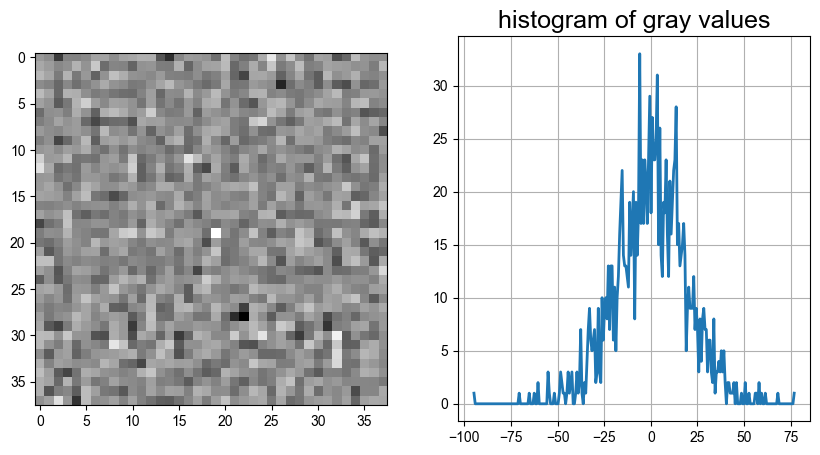

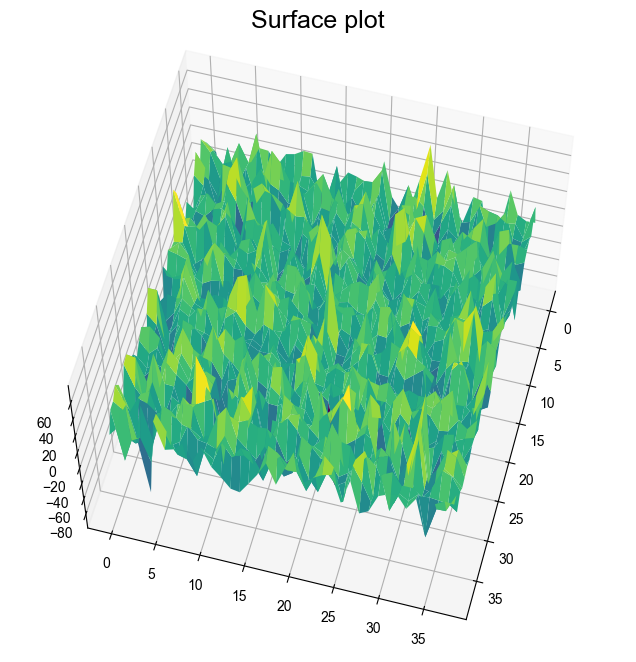

In [428]:
from skimage.exposure import histogram

# Histogram Plot
hist, hist_centers = histogram(first)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()

# 3D
Rn = np.shape(first)[0]
Cn = np.shape(first)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, first, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

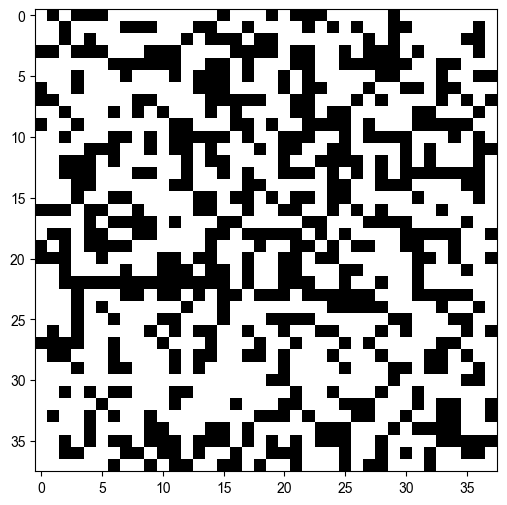

In [426]:
markers = np.zeros_like(first)

# To decide limits for the mask
# if ratioMin > ratioMax:
#     markers[file < LCL] = 1 # Tune your threshold
# else:
#     markers[file > UCL] = 1 # Tune your threshold

markers[first < LCL] = 1
markers[first > UCL] = 1

# markers[file > 10] = 1
    
# Contour and BBox
plt.figure()
plt.imshow(markers, cmap='gray')

ATTEMPT TO USE CONVOLUTIONAL LAYERS FROM CNN ON DATA

(UNSUCCESSFUL)

In [416]:
## CONVOLUTIONAL LAYER ATTEMPT

import torch
import torch.nn as nn

badcounter = 0 # Counter for identifying bad images
totalImages = (len(l0) + len(l45))//2

# Load some file in Manually Identified Bowties
# for i in range(0, len(l0)):
i = 13

filename0, filename45 = l0[i], l45[i]

file0, file45 = np.load(filename0), np.load(filename45)

variable = torch.zeros((1, 40, 40, 2))

# if file0.shape != (40, 40) or file45.shape != (40, 40):
#     badcounter += 1
#     continue

variable[0] = torch.from_numpy( np.dstack((file0, file45)) )

totalImages -= badcounter
all_data = variable[:totalImages]

variable = torch.permute(variable, (0, 3, 1, 2))

class DefectCnn(nn.Module):
    """
    Class that initializes a convolution
    
    """
    def __init__(self):
        super(DefectCnn, self).__init__()
        
        # First the convolution layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 1, (3, 3), padding = 'same'),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        return x
    
net = DefectCnn()

result = torch.zeros((1, 40, 40))

for i in range(0, len(variable)):
    result[i] = net(variable[i])

print(result)
print(result.shape)

tensor([[[-1.3725, -0.0152,  1.4009,  ...,  0.8315,  0.6257,  1.6352],
         [-0.7412,  1.2622,  3.2861,  ...,  2.7788,  2.2465,  6.5544],
         [-1.1664,  0.9454,  2.7980,  ...,  2.7582,  3.1548,  5.4186],
         ...,
         [-0.1686,  3.0141,  3.2163,  ..., -0.1007,  2.8049,  6.3108],
         [-1.1386,  2.7749, -0.1593,  ...,  1.1791,  2.0026,  6.1055],
         [-2.6550, -0.9461, -6.5344,  ..., -2.3482, -3.1328,  3.3385]]],
       grad_fn=<CopySlices>)
torch.Size([1, 40, 40])


In [1]:
from skimage.exposure import histogram

first = torch.tensor(result[0]).numpy()
from skimage.filters import gaussian
first = gaussian(first)
# Histogram Plot
hist, hist_centers = histogram(first)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()

# 3D
Rn = np.shape(first)[0]
Cn = np.shape(first)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, first, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

NameError: name 'torch' is not defined

AUTOMATED EXPERIMENTATION FOR CONVOLUTION LAYERS FROM CNN

(UNSUCCESSFUL)

In [319]:
import torch
import torch.nn as nn

badcounter = 0 # Counter for identifying bad images
totalImages = (len(l0) + len(l45))//2

# Load some file in Manually Identified Bowties
for i in range(0, len(l0)):
    filename0, filename45 = l0[i], l45[i]

    file0, file45 = np.load(filename0), np.load(filename45)

    variable = torch.zeros((len(l0), 40, 40, 2))

    if file0.shape != (40, 40) or file45.shape != (40, 40):
        badcounter += 1
        continue

    variable[i] = torch.from_numpy( np.dstack((file0, file45)) )

totalImages -= badcounter
all_data = variable[:totalImages]

variable = torch.permute(variable, (0, 3, 1, 2))

class DefectCnn(nn.Module):
    """
    Class that initializes a convolution
    
    """
    def __init__(self):
        super(DefectCnn, self).__init__()
        
        # First the convolution layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 1, (3, 3), padding = 'same'),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        return x
    
net = DefectCnn()

result = torch.zeros((len(l0), 40, 40))

for i in range(0, len(variable)):
    result[i] = net(variable[i])

print(result)
print(result.shape)

tensor([[[-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         ...,
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845]],

        [[-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         ...,
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845]],

        [[-0.0845, -0.0845, -0.0845,  ..., -0.0845, -0.0845, -0.0845],
         [-0.0845, -0.0845, -0.0845,  ..., -0

C:\Users\aaris\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


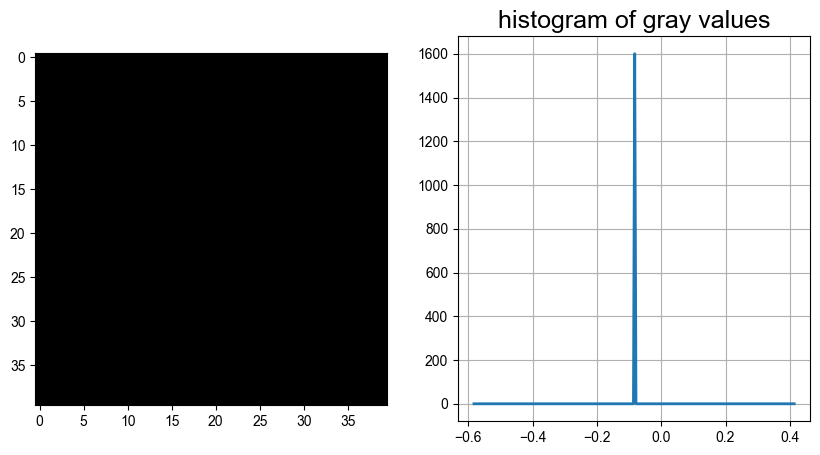

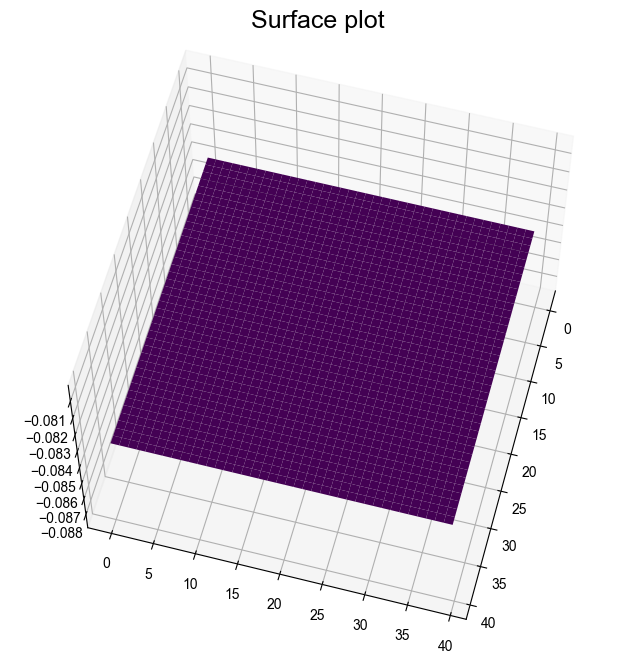

In [320]:
from skimage.exposure import histogram

first = torch.tensor(result[0]).numpy()
# Histogram Plot
hist, hist_centers = histogram(first)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()

# 3D
Rn = np.shape(first)[0]
Cn = np.shape(first)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, first, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

MANUAL EXPERIMENTATION FOR MASKING

In [28]:
# For a sliding window algorithm which processes images at 40 x 40 pixels at a time
# Adjust value of i for manual identification
i = 2

# Load some file in Manually Identified Bowties
filename = l45[i]

file = np.load(filename)

minimumValue = np.min(file)
maximumValue = np.max(file)
meanValue = np.mean(file)
stdValue = np.std(file)
    
# Use 3 sigma for upper and lower control limits
UCL = meanValue + 3*stdValue
LCL = meanValue - 3*stdValue

ratioMin = abs(minimumValue/meanValue)
ratioMax = abs(maximumValue/meanValue)

print(LCL, UCL)
print(minimumValue, maximumValue)
print(ratioMin, ratioMax)
print(file)

-13.626722694308917 12.346655951271593
-15.038564070036749 13.524914634768429
23.49653117985621 21.131577253037126
[[  2.84757006   3.89045887   5.91375669 ...  -5.81138397 -12.53150512
   -9.7920463 ]
 [  1.58754036   3.00241113   6.7055237  ...  -5.73318208  -9.80487652
   -7.28987118]
 [  2.20825077   5.22965487   5.98347632 ...  -4.86444489  -6.3065618
   -3.15048724]
 ...
 [  3.3342243    1.7063796    4.23272715 ...   3.06480684   4.09923969
    5.14476681]
 [  5.1523756    3.9055215    6.73468444 ...   0.6544354    2.77170079
    3.56769829]
 [  4.53859266   2.76447786   3.44676595 ...  -0.9349566    1.04889377
    0.0922087 ]]


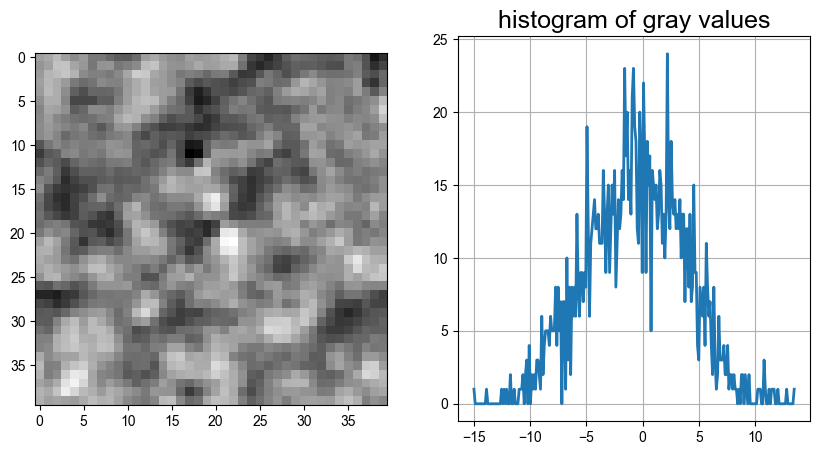

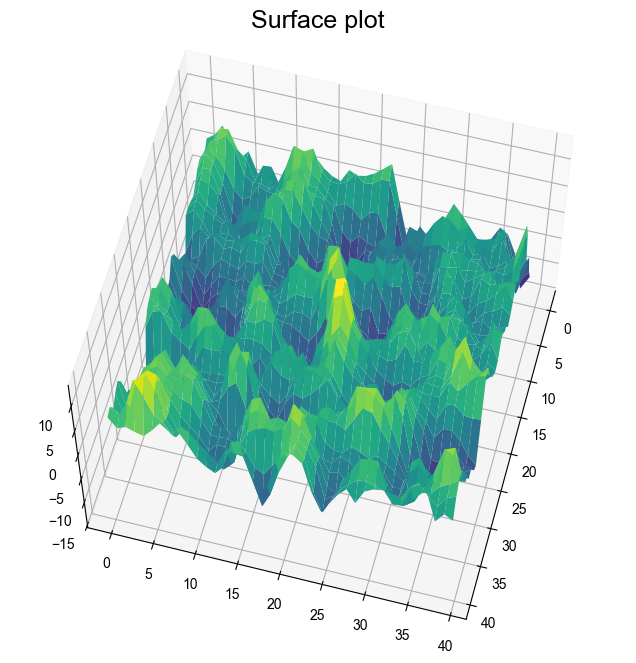

In [29]:
# Histogram Plot
hist, hist_centers = histogram(file)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(file, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()

# 3D
Rn = np.shape(file)[0]
Cn = np.shape(file)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, file, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

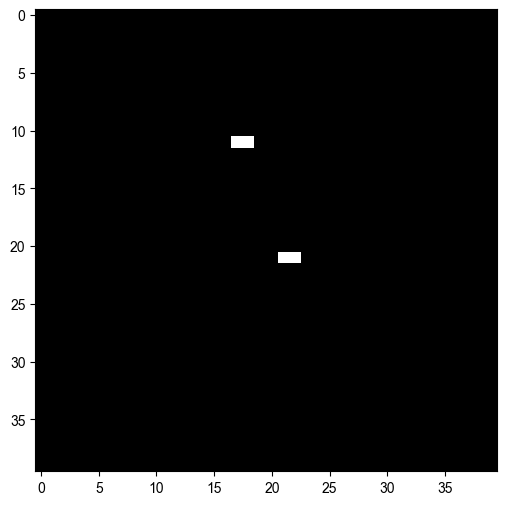

In [30]:
markers = np.zeros_like(file)

# To decide limits for the mask
# if ratioMin > ratioMax:
#     markers[file < LCL] = 1 # Tune your threshold
# else:
#     markers[file > UCL] = 1 # Tune your threshold

markers[file < LCL] = 1
markers[file > UCL] = 1

# markers[file > 10] = 1
    
# Contour and BBox
plt.figure()
plt.imshow(markers, cmap='gray')

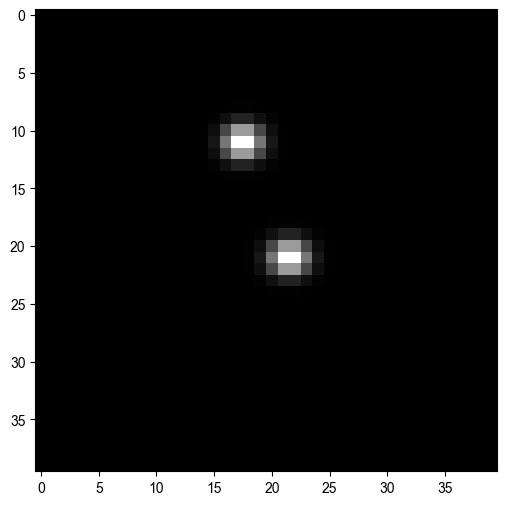

In [31]:
# Guassian filter
from skimage.filters import gaussian
filter_markers = gaussian(markers)
plt.imshow(filter_markers, cmap='gray')

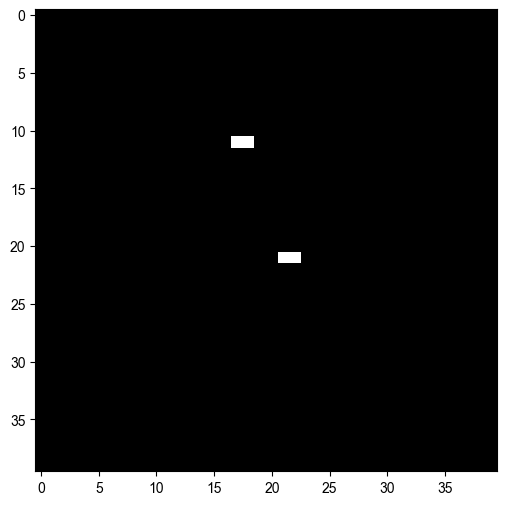

In [32]:
# Binary fill
fill_markers = ndi.binary_fill_holes(markers)
plt.imshow(fill_markers, cmap='gray')

c:\Users\aaris\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\color\colorlabel.py:129: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha, saturation)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


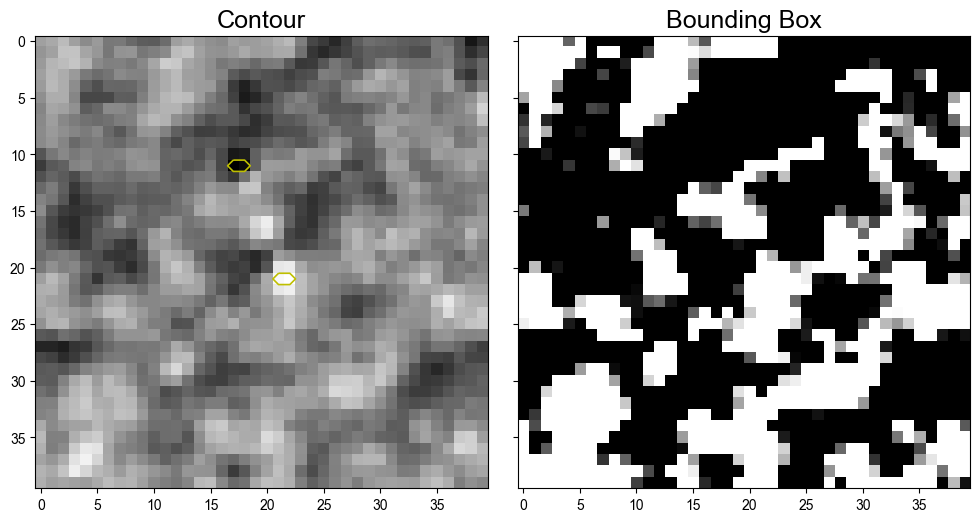

In [34]:
# Labeling connected components and measuring regions’ properties
markers = fill_markers # Choose which process your need, here I use the one from Binary fill
labeled_area, n = ndi.label(markers)  # label the connected components

image_label_overlay = label2rgb(labeled_area, image=file)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes[0].imshow(file, cmap=plt.cm.gray)
axes[0].contour(markers, [0.5], linewidths=1.2, colors='y')
axes[0].set_title('Contour')
axes[1].imshow(image_label_overlay)
axes[1].set_title('Bounding Box')

# Print the area info
i = 0
AT = 0
for region in regionprops(labeled_area):
    # If the area is small and not desired, ignore it
    if region.area < 4:
        continue

    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    axes[1].add_patch(rect)
    AT += region.area
    print('Area %i: Area %i' % (i, region.area))
    # print('Area %i: Area %i' % (i, region.bbox_area))
    i += 1

    print(region.area)
    
plt.tight_layout()

print(regionprops(labeled_area)[0].area)